#### Required libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

#### 16-17 data preparation - train data

In [4]:
hr_16_17 = pd.read_excel('E:/DataSkills 2021/Imarticus DSP/Capstone Project/HR Analytics/staff utlz latest 16-17_masked.xlsx',header=[0,1]).reset_index()
hr_16_17.columns = ['-'.join(col).strip() for col in hr_16_17.columns.values]
hr_16_17.drop('index-',axis=1,inplace=True)

col_list = [a.split('-')[-1] for a in hr_16_17.columns]
col_list[0]='Employee No'

for i in range(115):
    hr_16_17.rename(columns={hr_16_17.columns[i]:col_list[i]},inplace=True)

hr_16_17_1 = hr_16_17.iloc[:,107:115]
hr_16_17_2 = hr_16_17.iloc[:,0:11]

hr_16_17_total = pd.concat([hr_16_17_2,hr_16_17_1],axis=1)



hr_16_17_total.loc[hr_16_17_total['Termination Date']=='-','Termination Date'] = pd.to_datetime('2017-03-31')
hr_16_17_total[['Join Date','Termination Date']]=hr_16_17_total[['Join Date','Termination Date']].apply(pd.to_datetime)
hr_16_17_total[['Join Date','Termination Date']]=hr_16_17_total[['Join Date','Termination Date']].apply(lambda t: t.dt.floor('d'))

hr_16_17_total['Tenure']=hr_16_17_total['Termination Date']-hr_16_17_total['Join Date']
hr_16_17_total['Tenure']=hr_16_17_total['Tenure'].dt.days
hr_16_17_total['Tenure'] = hr_16_17_total['Tenure']/365

#### further data pre-processing for train data

In [35]:
# this feature can be removed
hr_16_17_total['People Group'].value_counts()

Client Service Staff    781
Support Staff             8
Name: People Group, dtype: int64

In [6]:
hr_16_17_total.loc[hr_16_17_total['Utilization%']=='-','Utilization%']=0
hr_16_17_total['Utilization%']=pd.to_numeric(hr_16_17_total['Utilization%'])

# removing employee details
hr_16_17_total.drop(['Employee No','Employee Name'],inplace=True,axis=1)

# kepping only two employee Current Status
hr_16_17_total.loc[hr_16_17_total['Current Status']!='Resigned','Current Status']='Active'

# Ordinal enconding of Employee Position feature
hr_16_17_total['Employee Position'].replace({'Level 7':7,'Level 8':8,'Level 6':6,'Level 5':5,
                                             'Level 4':4,'Level 3':3,'Level 2':2,'Level A3':10,
                                             'Level A2':10,'Level 10':9,'Level 1':1,'Level A1':10},inplace=True)

hr_16_17_category = hr_16_17_total[['Profit Center','Employee Location']] 
               
hr_16_17_numerical = hr_16_17_total[['Employee Position','Total Hours', 'Total Available Hours', 'Work Hours', 'Leave Hours',
                       'Training Hours', 'BD Hours', 'NC Hours', 'Utilization%', 'Tenure']]     

# One Hot enconding of categorical features
hr_16_17_category = pd.get_dummies(hr_16_17_category,drop_first=True)

# Encoding target feature (Current Status)
hr_16_17_total['Current Status'].replace({'Active':0,'Resigned':1},inplace=True)

# Preparing the cobined dataset 
hr_16_17_final=pd.concat([hr_16_17_category,hr_16_17_numerical,hr_16_17_total['Current Status']],axis=1)

#### Feature Selection

<AxesSubplot:>

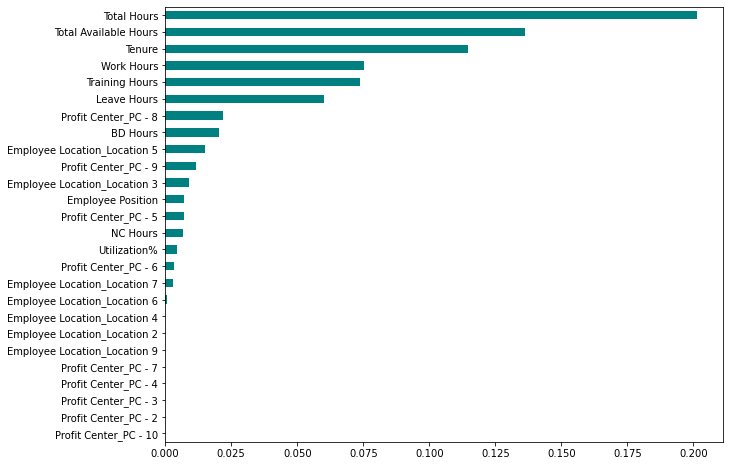

In [10]:
# Information Gain method
# feature selection by evaluating the Information gain of each variable in the context of the target variable

X = hr_16_17_final.drop('Current Status',axis=1)
y = hr_16_17_final['Current Status']
importance = mutual_info_classif(X,y)
plt.figure(figsize=(10,8));
feat_imp = pd.Series(importance,X.columns).sort_values()
feat_imp.plot(kind='barh',color='teal')

<AxesSubplot:>

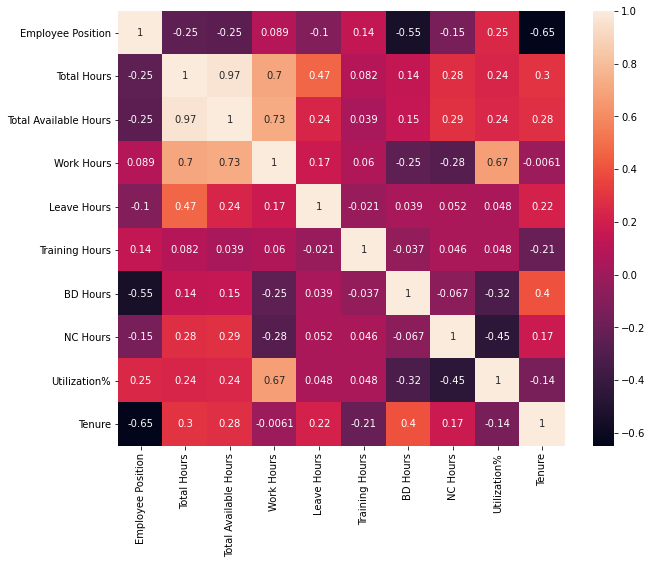

In [12]:
# Correlation matrix heatmap
plt.figure(figsize=(10,8));
sns.heatmap(hr_16_17_numerical.corr(),annot=True)

Correlation matrix heatmap - 'Total Hours' features can be removed as it is a redundant feature.

Information Gain method - 'Profit Center' and 'Employee Location' featues can be removed.

Found no prediction value in categorical-nominal features 

##### Final dataset for model building

In [25]:
hr_16_17_numerical_1 = hr_16_17_total[['Total Available Hours', 'Work Hours', 'Leave Hours',
                                       'Training Hours', 'BD Hours', 'NC Hours', 'Utilization%', 'Tenure']]

# scaling the numeric features
scaler = StandardScaler()
hr_16_17_numerical_scalled = scaler.fit_transform(hr_16_17_numerical_1)

hr_16_17_for_model = pd.concat([hr_16_17_total['Employee Position'],
                                pd.DataFrame(hr_16_17_numerical_scalled),
                                hr_16_17_total['Current Status']],axis=1)

# saving file to drive for model building
hr_16_17_for_model.to_csv('E:/DataSkills 2021/Imarticus DSP/Capstone Project/HR Analytics/hr_16_17_for_model.csv',index=False)

#### 17-18 data preparation - test data

In [29]:
hr_17_18 = pd.read_excel('E:/DataSkills 2021/Imarticus DSP/Capstone Project/HR Analytics/staff utlz latest 17-18_masked.xlsx',header=[0,1]).reset_index()

hr_17_18_1 = hr_17_18.iloc[:,108:116]
hr_17_18_2 = hr_17_18.iloc[:,0:12]
hr_17_18_total = pd.concat([hr_17_18_2,hr_17_18_1],axis=1)
#[hr_17_18.columns[i][0].strftime('%b-%Y') for i in range(12,108)]

hr_17_18_total.columns = ['-'.join(col).strip() for col in hr_17_18_total.columns.values]
hr_17_18_total.drop('index-',axis=1,inplace=True)

col_list = [a.split('-')[-1] for a in hr_17_18_total.columns]
# col_list[0]='Employee No'

for i in range(19):
    hr_17_18_total.rename(columns={hr_17_18_total.columns[i]:col_list[i]},inplace=True)

#hr_17_18_1 = hr_17_18.iloc[:,107:115]
#hr_17_18_2 = hr_17_18.iloc[:,0:11]

# hr_17_18_total = pd.concat([hr_hr_17_18_2,hr_hr_17_18_1],axis=1)

hr_17_18_total['Termination Date'].fillna(value=pd.to_datetime('2018-03-31'),inplace=True)
hr_17_18_total[['Join Date','Termination Date']]=hr_17_18_total[['Join Date','Termination Date']].apply(pd.to_datetime)
hr_17_18_total[['Join Date','Termination Date']]=hr_17_18_total[['Join Date','Termination Date']].apply(lambda t: t.dt.floor('d'))

hr_17_18_total['Tenure']=hr_17_18_total['Termination Date']-hr_17_18_total['Join Date']
hr_17_18_total['Tenure']=hr_17_18_total['Tenure'].dt.days
hr_17_18_total['Tenure'] = hr_17_18_total['Tenure']/365

##### further data pre-processing for test data

In [30]:
hr_17_18_total.loc[hr_17_18_total['Utilization%']=='-','Utilization%']=0
hr_17_18_total['Utilization%']=pd.to_numeric(hr_17_18_total['Utilization%'])

hr_17_18_total.drop(['Employee No','Employee Name'],inplace=True,axis=1)

hr_17_18_total.loc[hr_17_18_total['Current Status']!='Resigned','Current Status']='Active'
hr_17_18_total['Current Status'].replace({'Active':0,'Resigned':1},inplace=True)

hr_17_18_total['Employee Position'].value_counts()
hr_17_18_total['Employee Position'].replace({'Level 7':7,'Level 8':8,'Level 6':6,'Level 5':5,'-':10,
                                             'Level 4':4,'Level 3':3,'Level 2':2,'Level A3':10,
                                             'Level A2':10,'Level 10':9,'Level 1':1,'Level A1':10},inplace=True)

hr_17_18_numerical = hr_17_18_total[['Total Available Hours', 'Work Hours', 'Leave Hours',
                                     'Training Hours', 'BD Hours', 'NC Hours', 'Utilization%', 'Tenure']]     

# scaling the numeric features
hr_17_18_numerical_scalled = scaler.fit_transform(hr_17_18_numerical)

hr_17_18_for_model_testing = pd.concat([hr_17_18_total['Employee Position'],
                                        pd.DataFrame(hr_17_18_numerical_scalled),
                                        hr_17_18_total['Current Status']],axis=1)
# saving file to drive for model testing
hr_17_18_for_model_testing.to_csv('E:/DataSkills 2021/Imarticus DSP/Capstone Project/HR Analytics/hr_17_18_for_model_testing.csv',index=False)